In [1]:
import os, io, shutil
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sampler import MultiSampler
from tqdm.autonotebook import tqdm

import numpy as np
from tensorboardX import SummaryWriter
from dataloader.handhygiene import HandHygiene
from spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, RandomAffine, #ExtractSkinColor,
    RandomRotation, ColorJitter, ToTensor)
from temporal_transforms import (
    MirrorPadding, LoopPadding, TemporalBeginCrop, 
    TemporalRandomCrop, TemporalCenterCrop, TemporalRandomChoice)
from openpose_transforms import CropTorso, MultiScaleTorsoRandomCrop
from train import logger

/usr/local/lib/python3.5/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
model_name = 'i3d'
batch_size = 16
clip_len = 16
sample_duration = clip_len
num_classes = 1

#torch.manual_seed(100)
data_name = 'anesthesia'
dataset_path = os.path.join(os.getcwd(), 'data')

In [3]:
scales = 1.0
sample_size = 224
mean=[110.63666788, 103.16065604, 96.29023126]
std=[38.7568578, 37.88248729, 40.02898126]
#mean=[128, 128, 128]
#std=[128, 128, 128]

scales=np.linspace(1, 1.75, num=1e4)
openpose_transform = {
    'train':MultiScaleTorsoRandomCrop(scales, sample_size),
    'val':CropTorso(sample_size)}
#openpose_transform = None
spatial_transform = {
    'train': Compose([
            Scale(sample_size),
            CenterCrop(sample_size),
            RandomHorizontalFlip(),
            ColorJitter(brightness=0.1),
            RandomAffine(2.5),
            RandomRotation(2.5),
            ToTensor(1), 
            Normalize(mean, std)
    ]),
    'val': Compose([Scale(sample_size), CenterCrop(sample_size), 
                    ToTensor(1), Normalize(mean, std)])}
temporal_transform = {
    'train': TemporalRandomChoice([
            #TemporalBeginCrop(sample_duration),
            #TemporalRandomCrop(sample_duration),
            #TemporalCenterCrop(sample_duration),
            #LoopPadding(sample_duration),
            MirrorPadding(sample_duration)]),
    'val':TemporalCenterCrop(sample_duration)}

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [4]:
dataset = {
    'train':HandHygiene(dataset_path, split='train', clip_len=clip_len, 
                        spatial_transform=spatial_transform['train'],
                        openpose_transform=openpose_transform['train'],
                        temporal_transform=temporal_transform['train'], num_workers=16),
    'val':HandHygiene(dataset_path, split='val', clip_len=clip_len, 
                        spatial_transform=spatial_transform['val'],
                        openpose_transform=openpose_transform['val'],
                        temporal_transform=temporal_transform['val'], num_workers=16)}

length = dataset['train'].__len__()
dataloaders = {
    # sampler=MultiSampler(dataset['train'], length*10),
    'train': DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=16),
    'val': DataLoader(dataset['val'], batch_size=batch_size, shuffle=False, num_workers=16)}

Number of /data/private/minjee-video/handhygiene/data/images/train videos: 2100
Number of /data/private/minjee-video/handhygiene/data/images/train people: 1981
Number of /data/private/minjee-video/handhygiene/data/images/val videos: 107
Number of /data/private/minjee-video/handhygiene/data/images/val people: 103


In [5]:
from train import get_models
from train import train
from torchsummary import summary

MirrorPadding
size check: 19/16


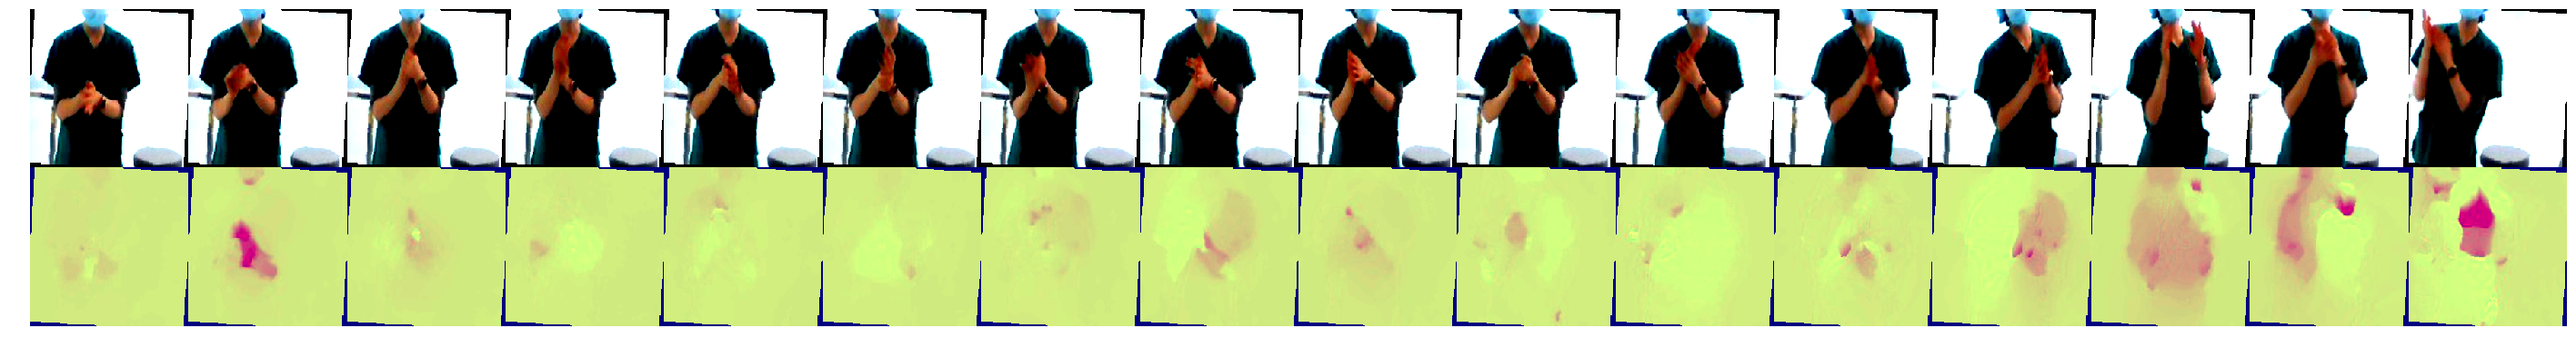

tensor([0])
/data/private/minjee-video/handhygiene/data/images/train/clean/38_20190119_frames000213


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_dataset(item): # item: C x D x 244 x 244
    rgbs = item[0].transpose(0, 1)
    flows = item[1].transpose(0, 1)
    n = len(rgbs)
    shape = np.asarray(flows[0]).shape
    rgb = np.hstack((np.asarray(rgb).transpose(1, 2, 0)+1)/2 for rgb in rgbs)
    #gray = np.hstack((np.squeeze(np.asarray(gray))+1)/2 for gray in rgbs)
    tmp = np.zeros((shape[1], shape[2], 1))
    flow = np.hstack((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2 for flow in flows)

    img = np.vstack((rgb, flow))
    plt.figure(figsize=(50, 10))
    plt.imshow(img)
    #plt.imshow(gray)
    plt.axis('off')
    plt.show()
    print(item[2])

i=50
phase='train'
show_dataset(dataset[phase].__getitem__(i))
print(dataset[phase].__getpath__(i))

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
i3d_rgb, i3d_flow = get_models(num_classes, True, 170, load_pt_weights=True) # unfreeze last mix 170, 152
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    i3d_rgb = nn.DataParallel(i3d_rgb)
    i3d_flow = nn.DataParallel(i3d_flow)
i3d_rgb.to(device)
i3d_flow.to(device)

criterion = F.binary_cross_entropy
optims={'rgb':None, 'flow':None}
schedulers = {'rgb':None, 'flow':None}
feature_extract=True

Let's use 2 GPUs!


In [8]:
def trainable_params(model, mode='rgb'):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    optims[mode] = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9, weight_decay=1e-7)

trainable_params(i3d_rgb, 'rgb')
trainable_params(i3d_flow, 'flow')
    
schedulers['rgb'] = MultiStepLR(optims['rgb'], milestones=[200,275], gamma=0.1)
schedulers['flow'] = MultiStepLR(optims['flow'], milestones=[300,375], gamma=0.1)

Params to learn:
	 module.conv3d_0c_1x1.0.conv3d.weight
	 module.conv3d_0c_1x1.0.conv3d.bias
	 module.conv3d_0c_1x1.1.conv3d.weight
	 module.conv3d_0c_1x1.1.conv3d.bias
Params to learn:
	 module.conv3d_0c_1x1.0.conv3d.weight
	 module.conv3d_0c_1x1.0.conv3d.bias
	 module.conv3d_0c_1x1.1.conv3d.weight
	 module.conv3d_0c_1x1.1.conv3d.bias


# summary(i3d_rgb, (3, 64, 224, 224))

In [9]:
train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch 0/1
MirrorPadding
MirrorPadding
MirrorPadding
MirrorPadding
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
MirrorPadding
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
size check: 16/16
size check: 16/16
size check: 16/16
size check: 16/16
size check: 16/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 32/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/1

MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 29/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 36/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPa

MirrorPadding
size check: 16/16
MirrorPadding
size check: 21/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 17/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 32/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 235/16
MirrorPadding
size check: 31/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorP

size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 28/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
size check: 16/16
MirrorPadding
MirrorPadding
size check: 25/16
MirrorPadding
size check: 27/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 18/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
Mirr

MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 38/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPa

MirrorPadding
size check: 16/16
MirrorPadding
size check: 117/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 35/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 42/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check:

MirrorPadding
size check: 16/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPa

size check: 16/16
size check: 21/16
MirrorPadding
size check: 17/16
MirrorPadding
MirrorPadding
size check: 16/16
MirrorPadding
MirrorPadding
size check: 16/16
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 17/16
MirrorPadding
size check: 64/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size che

RuntimeError: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 232, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 232, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 209, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 16 and 7 in dimension 2 at /pytorch/aten/src/TH/generic/THTensorMoreMath.cpp:1333


MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 112/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorPadding
size check: 16/16
MirrorP

In [13]:
dataset['train'].__getitem__(1003)[0].shape

MirrorPadding
/data/private/minjee-video/handhygiene/data/images/train/notclean/41_20190211_frames163889


torch.Size([3, 7, 224, 224])

In [10]:
for i in range(dataset['train'].__len__()):
    if dataset['train'].__getpath__(i) == '/data/private/minjee-video/handhygiene/data/images/train/notclean/41_20190211_frames163889':
        print(i)
    #print(dataset['train'].__getitem__(1003))
    #path = dataset['train'].__getpath__(i)
    #num_images = len(glob(os.path.join(path, '*.jpg'))) 
    #if num_images < 16:
    #    print(path, num_images)
    
    #print(dataset['train'].__getitem__(i))
    

1003


In [11]:
dataset['train'].samples[1][1003]

{'people': [[277, 108, 61, 61],
  [279, 107, 66, 64],
  [277, 110, 69, 66],
  [266, 111, 71, 69],
  [266, 112, 71, 70],
  [270, 112, 69, 78],
  [275, 114, 70, 77]],
 'torso': [[285.035, 108.789],
  [277.194, 144.053],
  [298.138, 162.38],
  [333.328, 110.174],
  [338.56, 147.995],
  [319.006, 170.196]]}

In [ ]:
from glob import glob
paths = glob('/data/private/minjee-video/handhygiene/data/images/train/notclean/31_20181231_frames001191*')

In [ ]:
for path in paths:
    print(os.path.join(path, '*.jpg'))
    print(len(glob(os.path.join(path, '*.jpg'))))

In [ ]:
len(glob('/data/private/minjee-video/handhygiene/data/images/train/notclean/31_20181231_frames001191_5/*.jpg'))